In [1]:
#Import standard packages for model training

import tensorflow as T
from tensorflow import *
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
import numpy as np
import pandas as pd
import sklearn.metrics as SK
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import io
from utils.GPU import *
from utils import utils
commons = utils.Commons()
ts_helper = utils.TS_Helper()
ts_helper.model_type = ts_helper.Regression
shap_helper = utils.Shap_Helper()

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

  tensorlayer: GPU MEM Fraction 0.900000
Num GPUs Available:  0


In [2]:
#Inport train, validation and test sets

training = './data/regression/Tb.rhodesiense/random_split/train_fold_4.csv'
validation = './data/regression/Tb.rhodesiense/random_split/valid_fold_4.csv'
test = './data/regression/Tb.rhodesiense/random_split/test_fold_4.csv'
SMILES = 'SMILES'
TASK_START = 2
NUM_TASKS = 1
train_dataset,y_train,train_smiles = commons.load_dataset(training,SMILES,TASK_START,NUM_TASKS)
valid_dataset,y_val,val_smiles = commons.load_dataset(validation,SMILES,TASK_START,NUM_TASKS)
test_dataset,y_test,test_smiles = commons.load_dataset(test,SMILES,TASK_START,NUM_TASKS)


train_dataset.head()

Loaded dataset ./data/regression/Tb.rhodesiense/random_split/train_fold_4.csv with shape: (1430, 3)
Loaded dataset ./data/regression/Tb.rhodesiense/random_split/valid_fold_4.csv with shape: (179, 3)
Loaded dataset ./data/regression/Tb.rhodesiense/random_split/test_fold_4.csv with shape: (179, 3)


,ID,SMILES,Tb_rhodesiense
0,2357,O=C(C1C=CC(C2NCCN=2)=CC=1)NC1C=C(C(NC2C=CC(C3N...,6.920819
1,291,CC1C=C(Br)C(NC2N=C(NC3C=CC(C#N)=CC=3)N=C(C#N)N...,4.877129
2,2054,FC(OC1C(Cl)=CC(CC(C(NC2(C#N)CC2)=O)NC(C2C=NN(C...,9.000000
3,3455,CCCCCCCCCCCCCCCCC1(C(=O)C(CCC)=C(O)S1)C,4.537602
4,2313,CN(C12CC(C3C=CC=CC=3)C(C(C3C=CC=CC=3)C1)C(OC(C...,7.096910


In [3]:
# calculate ECFP (defaut) fingerprints using RDKit
FP_SIZE = 2048
RADIUS = 2
FEAT = False
X_train = commons.assing_fp(train_smiles,FP_SIZE,RADIUS,FEAT)
X_val = commons.assing_fp(val_smiles,FP_SIZE,RADIUS,FEAT)
X_test = commons.assing_fp(test_smiles,FP_SIZE,RADIUS,FEAT)

type(X_train), X_val.shape, X_test.shape

(numpy.ndarray, (179, 2048), (179, 2048))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                30735     
                                                                 
 dropout (Dropout)           (None, 15)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                

c:\Users\Laplace\anaconda3\envs\AI\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


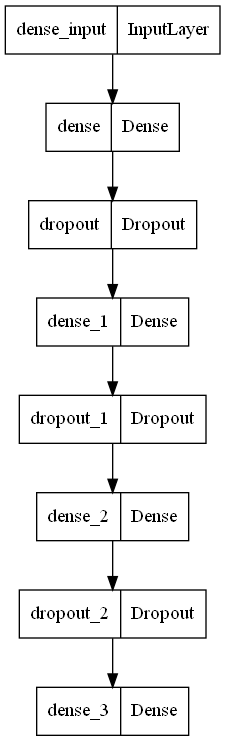

In [4]:
#Parameters for train network

from utils.utils import *

bit_vector = X_train.shape[1]

def create_model():
    return T.keras.models.Sequential([
            T.keras.layers.Dense(15,input_dim=bit_vector, activation='relu'),
            T.keras.layers.Dropout(0.3),
            T.keras.layers.Dense(10, activation='relu'),
            T.keras.layers.Dropout(0.1),
            T.keras.layers.Dense(10, activation='relu'),
            T.keras.layers.Dropout(0.1),
            T.keras.layers.Dense(NUM_TASKS, activation='linear'),
            ])

       
optimizer = RMSprop(lr=0.001)
lr_metric = ts_helper.get_lr_metric(optimizer)
model = create_model()
model.compile(loss=ts_helper.regression_loss, metrics = [lr_metric])    
model.summary()
T.keras.utils.plot_model(model)

In [5]:
# Early stopping parameters

callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=0.00000001, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="./data/TM-FNN_regression_model.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto'),
    EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min', verbose=1)
    ]


# parameters for train network

epochs=1000
batch_size=40

history = model.fit(X_train, y_train, 
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    callbacks=(callbacks_list))

Epoch 1/1000
 1/36 [..............................] - ETA: 23s - loss: 35.1480 - lr: 0.0010
Epoch 1: val_loss improved from inf to 26.70763, saving model to ./data\TM-FNN_regression_model.hdf5
36/36 [==============================] - 1s 6ms/step - loss: 32.8306 - lr: 0.0010 - val_loss: 26.7076 - val_lr: 0.0010
Epoch 2/1000
 1/36 [..............................] - ETA: 0s - loss: 27.9536 - lr: 0.0010
Epoch 2: val_loss improved from 26.70763 to 13.04100, saving model to ./data\TM-FNN_regression_model.hdf5
36/36 [==============================] - 0s 2ms/step - loss: 23.1673 - lr: 0.0010 - val_loss: 13.0410 - val_lr: 0.0010
Epoch 3/1000
 1/36 [..............................] - ETA: 0s - loss: 18.5559 - lr: 0.0010
Epoch 3: val_loss improved from 13.04100 to 4.15765, saving model to ./data\TM-FNN_regression_model.hdf5
36/36 [==============================] - 0s 2ms/step - loss: 12.0542 - lr: 0.0010 - val_loss: 4.1577 - val_lr: 0.0010
Epoch 4/1000
 1/36 [..............................] - ETA:

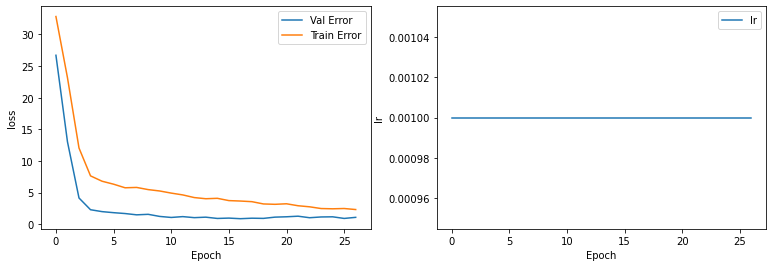

In [6]:
#Plot model history
ts_helper.plot_history(history)

(1430, 2048) (1430, 1)
(179, 2048) (179, 1)
(179, 2048) (179, 1)
Metric for a Regression Model
6/6 [==============================] - 0s 1000us/step
For Training in task 0 
 Statistic       Value
-----------  --------
MSE          1.10982
MAE          0.863236
R2           0.349823
For Validation in task 0 
 Statistic       Value
-----------  --------
MSE          1.09852
MAE          0.873201
R2           0.195351
For Testing in task 0 
 Statistic       Value
-----------  --------
MSE          1.00844
MAE          0.801246
R2           0.365164


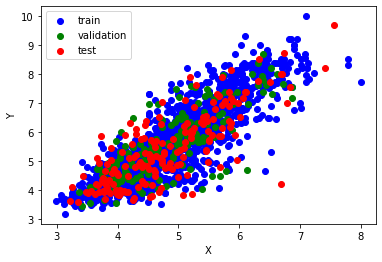

In [7]:
#Statistical characteristico of model without 3-sigma rule
THRESHOLD = 0.5
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)
ts_helper.get_modelStats(model, X_train, y_train, X_test, y_test,X_val, y_val,NUM_TASKS,THRESHOLD)